In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
frac_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/class_fractions_3.nc'
flux_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/carbon_fluxes.nc'

frac = xr.open_dataset(frac_file)
flux = xr.open_dataset(flux_file)

In [3]:
# List of flux variables to compute
flux_keys = ['NEP', 'GPP', 'RECO', 'BAL']

# Output container
result_dataarrays = {}

# Reference variable to get dimensions/coordinates
ref_var = next(iter(frac.data_vars))

# Loop over each class
for flux_key in flux_keys:
    terms = []
    class_idx = 1

    # Iterate through indices (ALL = 1-12, metsämaa = 1-4, joutomaa = 1-8)
    for id in range(1, 13):
        frac_key = f'class_{class_idx}'
        flux_var = f'{flux_key}_{id}'

        terms.append(frac[frac_key] * flux[flux_var])
        
        class_idx += 1

    if not terms:
        continue

    # Stack terms and perform safe summing
    stacked = np.stack(terms)
    result_array = np.where(
        np.all(np.isnan(stacked), axis=0),
        np.nan,
        np.nansum(stacked, axis=0)
    )

    # Construct DataArray
    result_dataarrays[flux_key] = xr.DataArray(
        result_array,
        dims=frac[ref_var].dims,
        coords=frac[ref_var].coords,
        name=flux_key,
        attrs={'units': 'g C m-2 a-1'}
    )

# Final dataset
flux_dataset = xr.Dataset(result_dataarrays)

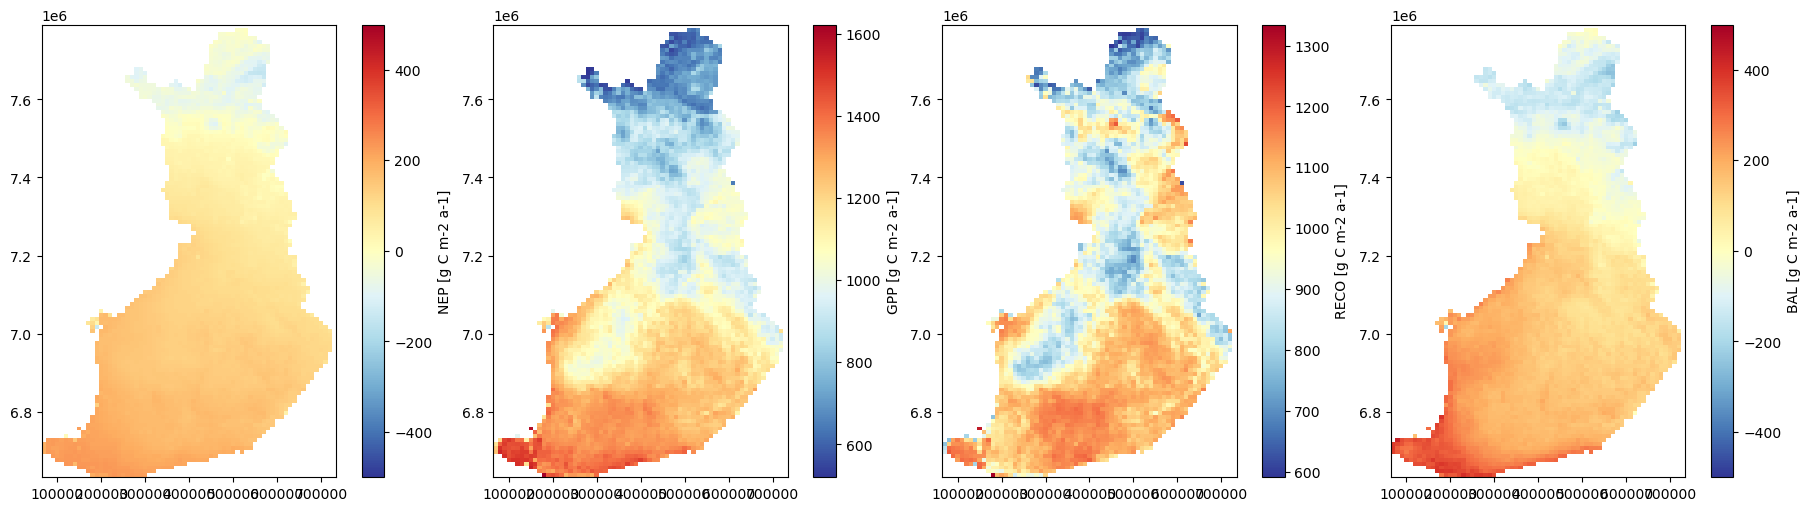

In [4]:
fig_file = f'/scratch/project_2000908/nousu/mNFI_to_NEP/FIGS/scaled_fluxes_3.png'

# Create figure and subplots: one subplot per variable
nvars = len(flux_dataset.data_vars)
fig, axes = plt.subplots(1, nvars, figsize=(18, 5), constrained_layout=True)

# Ensure axes is iterable
if nvars == 1:
    axes = [axes]

# Plot each variable in its own subplot
for ax, var_name in zip(axes, flux_dataset.data_vars):
    plot_kwargs = {'ax': ax, 'cmap': 'RdYlBu_r'}
    if var_name in ['NEP', 'BAL']:
        plot_kwargs.update({'vmin': -500, 'vmax': 500})

    flux_dataset[var_name].plot(**plot_kwargs)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Save to file
#plt.savefig(fig_file, dpi=300, bbox_inches='tight')

In [5]:
output_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/scaled_carbon_fluxes_3.nc'
flux_dataset.to_netcdf(output_file)
flux_dataset.close()